# **K-nearest neighbors with dynamic time warping**

* Classify failures from force and torque measurements of a robot
over time.
* Combine TSFresh's feature extraction in a pipeline with a kNN
algorithm.

* Install tsfresh.

In [1]:
!pip install tsfresh "statsmodels<=0.12"

* Install tslearn.

In [2]:
!pip install tslearn

     |████████████████████████████████| 793 kB 5.2 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

* Download a dataset of robotic execution failures from the UCI machine learning repository and store it locally.
* This dataset contains force and
torque measurements on a robot after failure detection.

In [4]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


* Extract time-series features using TSFresh.
* Impute missing values and select features based on relevance to the target.
* In TSFresh, the p-value from a statistical test is used to
calculate the feature significance.

In [5]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = impute(extract_features(df_ts, column_id="id", column_sort="time"))
features_filtered = select_features(extracted_features, y)

Feature Extraction: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]
/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__matrix_profile__feature_"median"__threshold_0.98'
 'T_z__matrix_profile__feature_"25"__threshold_0.98'
 'T_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


* The columns include the time and six time-series with signals from the sensors, F_x, F_y, F_z, T_x, T_y, and T_z. 
* The target variable, y, which can take the values True or False, indicates if there was a failure.

In [6]:
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

X = pd.DataFrame(index=y.index)
TRAINING_SIZE = (len(X) // 10) * 8
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time')
augmenter.set_timeseries_container(df_ts[:TRAINING_SIZE])
augmenter.fit(X[:TRAINING_SIZE], y[:TRAINING_SIZE])
X_transformed = augmenter.transform(X)

Feature Extraction: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]
/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__matrix_profile__feature_"median"__threshold_0.98'
 'T_z__matrix_profile__feature_"25"__threshold_0.98'
 'T_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)
Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 19204.69it/s]


* Find some good values for the number of neighbors by doing a grid search.
* Use scikit-learn's TimeSeriesSplit to split the time-series.

In [7]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_search = {
    'metric' : ['dtw'],  # ctw', 'dtw', "softdtw"], # TSLEARN_VALID_METRICS}
    'n_neighbors': [1, 2, 3]
}
#  'param_grid': {'metric': ['ctw', 'dtw', 'gak', 'sax', 'softdtw', 'lcss']},
tscv = TimeSeriesSplit(n_splits=2)

gsearch = GridSearchCV(
    estimator=knn,
    cv=tscv,
    param_grid=param_search
)
gsearch.fit(
    features_filtered,
    y
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'metric': ['dtw'], 'n_neighbors': [1, 2, 3]})

In [8]:
# Adapted from comments on this discussion thread on stackoverflow: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


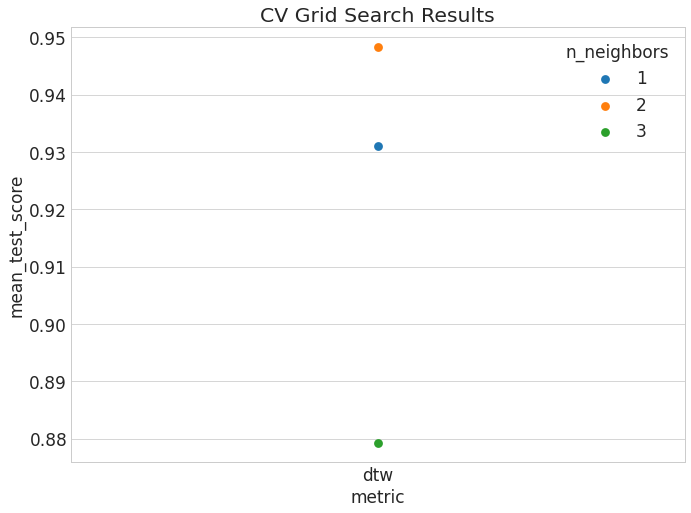

In [9]:
fig = plot_cv_results(gsearch.cv_results_, 'metric', 'n_neighbors')